In [ ]:
# 닥터나우 
# id : 1513718380

# tigerconnect
# id : 355832697

# https://zzsza.github.io/development/2019/03/12/crawling-in-developer-tools-console/
# https://kibua20.tistory.com/196

#닥터나우

In [1]:
!pip install xmltodict

In [2]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy wordcloud

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 https://developer.download.nvidia.com/compute/c

In [3]:
!apt-get install fonts-nanum*
!apt-get install fontconfig
!fc-cache -fv
!cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
!rm -rf /content/.cache/matplotlib/*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-gothic-light' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 4 newly installed, 0 to remove and 70 not upgraded.
Need to get 37.0 MB of archives.
After this operation, 145 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum-eco all 1.000-6 [14.0 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum-extra all 20170925-1 [12.2 MB]
Get:4 http://archive.ubu

In [4]:
import pandas as pd
import xmltodict 
import requests 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt
import json
import re
from bs4 import BeautifulSoup
import warnings
import numpy as np
from konlpy.tag import Twitter
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!/usr/bin/python3 # -*- coding: utf-8 -*- 

def get_url_index(url): 
  response = requests.get(url).content.decode('utf8') 
  xml = xmltodict.parse(response) 
  last_url = [l['@href'] for l in xml['feed']['link'] if (l['@rel'] == 'last')][0] 
  last_index = [int(s.replace('page=', '')) for s in last_url.split('/') if ('page=' in s)][0] 
  return last_index 
  
  # https://stackoverflow.com/questions/1090282/api-to-monitor-iphone-app-store-reviews 
def appstore_crawler(appid, outfile='./appstore_reviews.csv'): 
  url = 'https://itunes.apple.com/kr/rss/customerreviews/page=1/id=%i/sortby=mostrecent/xml' % appid 
  try: 
    last_index = get_url_index(url) 
  except Exception as e: 
    print (url) 
    print ('\tNo Reviews: appid %i' %appid)
    print ('\tException:', e) 
    return 
      
  result = list() 
  for idx in range(1, last_index+1): 
    url = "https://itunes.apple.com/kr/rss/customerreviews/page=%i/id=%i/sortby=mostrecent/xml?urlDesc=/customerreviews/id=%i/sortBy=mostRecent/xml" % (idx, appid, appid) 
    print(url) 
    response = requests.get(url).content.decode('utf8') 
    try: 
      xml = xmltodict.parse(response) 
    except Exception as e: 
      print ('\tXml Parse Error %s\n\tSkip %s :' %(e, url)) 
      continue 
    try: 
      num_reivews= len(xml['feed']['entry']) 
    except Exception as e: 
      print ('\tNo Entry', e) 
      continue 
    
    try: 
      xml['feed']['entry'][0]['author']['name'] 
      single_reviews = False 
    except: 
      #print ('\tOnly 1 review!!!') 
      single_reviews = True 
      pass 
    
    if single_reviews: 
      result.append({ 'USER': xml['feed']['entry']['author']['name'], 
                      'DATE': xml['feed']['entry']['updated'], 
                      'STAR': int(xml['feed']['entry']['im:rating']), 
                      'LIKE': int(xml['feed']['entry']['im:voteSum']), 
                      'TITLE': xml['feed']['entry']['title'], 
                      'REVIEW': xml['feed']['entry']['content'][0]['#text'], }) 
    else: 
      for i in range(len(xml['feed']['entry'])): 
        result.append({ 'USER': xml['feed']['entry'][i]['author']['name'], 
                        'DATE': xml['feed']['entry'][i]['updated'], 
                        'STAR': int(xml['feed']['entry'][i]['im:rating']), 
                        'LIKE': int(xml['feed']['entry'][i]['im:voteSum']), 
                        'TITLE': xml['feed']['entry'][i]['title'], 
                        'REVIEW': xml['feed']['entry'][i]['content'][0]['#text'], }) 
  res_df = pd.DataFrame(result) 
  res_df['DATE'] = pd.to_datetime(res_df['DATE'], format="%Y-%m-%dT%H:%M:%S") 
  res_df.to_csv(outfile, encoding='utf-8-sig', index=False) 
  print ('Save reviews to file: %s \n' %(outfile)) 

if __name__ == '__main__': 
  app_id = 1513718380 
  outfile = os.path.join('/content/drive/MyDrive/puzzleAI/스토어 앱리뷰 분석/'+'appstore_' + str(app_id)+'.csv') 
  appstore_crawler(app_id, outfile=outfile)


https://itunes.apple.com/kr/rss/customerreviews/page=1/id=1513718380/sortby=mostrecent/xml?urlDesc=/customerreviews/id=1513718380/sortBy=mostRecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=2/id=1513718380/sortby=mostrecent/xml?urlDesc=/customerreviews/id=1513718380/sortBy=mostRecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=3/id=1513718380/sortby=mostrecent/xml?urlDesc=/customerreviews/id=1513718380/sortBy=mostRecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=4/id=1513718380/sortby=mostrecent/xml?urlDesc=/customerreviews/id=1513718380/sortBy=mostRecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=5/id=1513718380/sortby=mostrecent/xml?urlDesc=/customerreviews/id=1513718380/sortBy=mostRecent/xml
https://itunes.apple.com/kr/rss/customerreviews/page=6/id=1513718380/sortby=mostrecent/xml?urlDesc=/customerreviews/id=1513718380/sortBy=mostRecent/xml
Save reviews to file: /content/drive/MyDrive/puzzleAI/스토어 앱리뷰 분석/appstore_151

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/puzzleAI/스토어 앱리뷰 분석/appstore_1513718380.csv')
df

,USER,DATE,STAR,LIKE,TITLE,REVIEW
0,hurururice,2021-08-31 06:09:04-07:00,5,0,너무 편리합니다,진짜 약 배송 완전 빠르고 의사 쌤 진료 친절하게 해줘요
1,제니퍼79,2021-08-30 23:08:13-07:00,5,0,신세계를 경험한 오늘,새벽부터 아파서 일어나서 병원가야지 했는데\n눈 뜨고 보니 밖엔 어마무시하게 비가 ...
2,으엥 우엥 으에엥,2021-08-27 14:18:10-07:00,5,1,진짜 편하고 좋아요 ㅠ,아픈데 열이 있어서 병원 외래 갔다가 빠꾸 당해서 슬펐었는데 비대면 진료 덕분에 살...
3,뙁윋,2021-08-24 08:11:11-07:00,5,1,.,원래 리뷰 잘 안 쓰는데 진짜 신기해서 작성하러 왔어요 어떻게 이런 굿아이디어를 생...
4,아아아ㅏ댲,2021-08-24 01:59:56-07:00,1,0,이거 왜별점높아요?,상담원 연결도 느려~ 답도없어~ 고샌도없고~ 카드등록도 불가능하고 어우 속터져
...,...,...,...,...,...,...
271,ㅜ우우ㅜㅎ우우,2020-11-19 06:32:39-07:00,5,2,서비스가 활성화 되었으면 좋겠네요!,병원이나 약국에 접근성이 떨어지는 환자들에게 정말 도움이 많이 되겠네요!! 특히 이...
272,꼬으니08,2020-10-26 01:13:54-07:00,2,0,????,알람모에요?
273,에어파트프로,2020-09-07 18:47:39-07:00,1,0,별로에요,Ui/ux도 별로라서 롯데온 같네요
274,Aplus2781,2020-09-06 16:01:07-07:00,1,1,약이 배달이 가능하려면,진료부터 원격진료가 되야 배달이 가능해지지 않을까요? 굳이 진료를 받으러 병원 갔다...


In [ ]:
df = df.sort_values(by='DATE', ascending=False).reindex()

In [ ]:
print("최소 :", min(df['DATE'].value_counts().index))
print("최대 :", max(df['DATE'].value_counts().index))

최소 : 2020-09-01 19:56:13-07:00
최대 : 2021-08-31 06:09:04-07:00


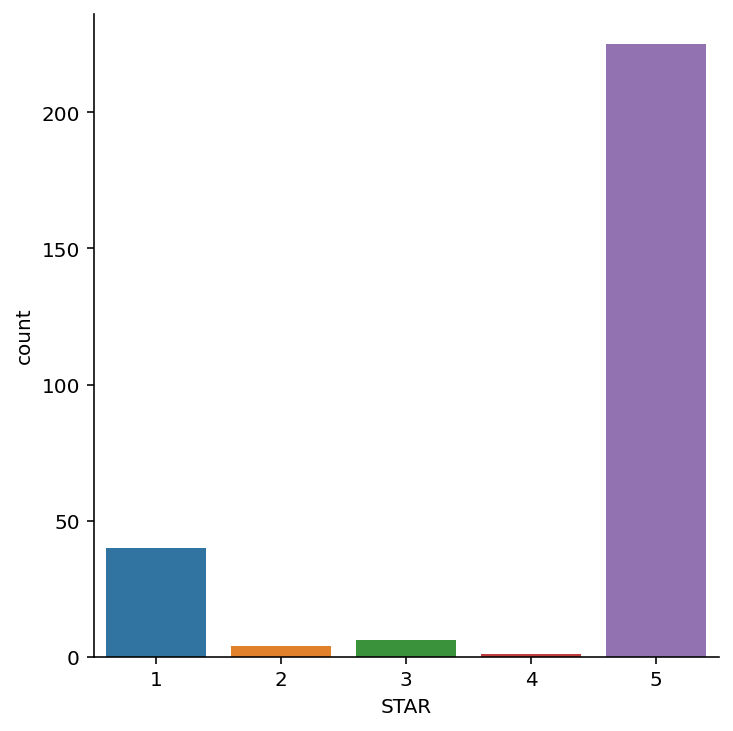

In [ ]:
sns.factorplot('STAR',kind='count',data=df)

In [ ]:
df['STAR'].value_counts()

5    225
1     40
3      6
2      4
4      1
Name: STAR, dtype: int64

In [ ]:
high_rate_review = df[df['STAR'] == 5]['REVIEW']
low_rate_review = df[df['STAR'] <= 3]['REVIEW']

In [ ]:
len(high_rate_review)

225

In [ ]:
len(low_rate_review)

44

In [ ]:
low_rate_review[:10]

4           상담원 연결도 느려~ 답도없어~ 고샌도없고~ 카드등록도 불가능하고 어우 속터져
22            ㅡㅡ 약국이 이 어플이 불법이라고 처방을 안해줘요 돈만 날림..빡침..ㅡㅡ
33    아파서 약지어서 3일후에 먹는 사람도 있나요? \n급하고 외출 할수 없을만한 사정이...
60    제휴약국 없음. \n매칭안되서 여러번 약국찾기 하는중 \n^^ 조금 더 외곽사는 사...
61    별 한개도 주기 아까움\n집 주소 입력 하니까 한시간 안심 배달 가능하다고 했으면서...
62    의사답지않은 사람들이 의사를 하고있으니\n인성에 문제있는 병원들은 좀 올려놓지마세요...
63                                              배달은무슨 ㅜ
65    어느 주소든지 오는게 아니라면 적어도 처방전에 본인 주소가 약 배송이 되는지 확인이...
66                                        별로 한번써보고 바로지움
67    사람 뺑뺑이 돌리는거도 아니고\n개짜증 지대로네요\n광고보고 이게 되나 싶어서 썻는...
Name: REVIEW, dtype: object

In [ ]:
high_rate_review = high_rate_review.apply(lambda x:re.sub('[^가-힣\s\d]',"",x))
low_rate_review = low_rate_review.apply(lambda x:re.sub('[^가-힣\s\d]',"",x))

In [ ]:
high_rate_review[:10]

0                       진짜 약 배송 완전 빠르고 의사 쌤 진료 친절하게 해줘요
1     새벽부터 아파서 일어나서 병원가야지 했는데\n눈 뜨고 보니 밖엔 어마무시하게 비가 ...
2     아픈데 열이 있어서 병원 외래 갔다가 빠꾸 당해서 슬펐었는데 비대면 진료 덕분에 살...
3     원래 리뷰 잘 안 쓰는데 진짜 신기해서 작성하러 왔어요 어떻게 이런 굿아이디어를 생...
5                                               지방은 불가능
7     딴데는 비대면 진료만 되지 약 배달 잘 되는데는 없었는데 이거는 약 배달까지 잘되니...
8                 더워서 어디 나가기 겁나는데 요럴 때 잘 사용할 수 있을 것 같아요
9                의사 선생님이 대기 시간도 거의 없이 바로 진료 봐주셔서 괜찮았습니다
10                집 나와서 병원가서 기다리고 하는 시간 생각하면 진짜 엄청난듯하네여
11    쿠팡 이츠나 배민처럼 배달이 빠른 편은 아니지만 그래도 이정도면 괜찮은듯 나중에 더...
Name: REVIEW, dtype: object

In [ ]:
low_rate_review[:10]

4              상담원 연결도 느려 답도없어 고샌도없고 카드등록도 불가능하고 어우 속터져
22                     약국이 이 어플이 불법이라고 처방을 안해줘요 돈만 날림빡침
33    아파서 약지어서 3일후에 먹는 사람도 있나요 \n급하고 외출 할수 없을만한 사정이 ...
60    제휴약국 없음 \n매칭안되서 여러번 약국찾기 하는중 \n 조금 더 외곽사는 사람들은...
61    별 한개도 주기 아까움\n집 주소 입력 하니까 한시간 안심 배달 가능하다고 했으면서...
62    의사답지않은 사람들이 의사를 하고있으니\n인성에 문제있는 병원들은 좀 올려놓지마세요...
63                                               배달은무슨 
65    어느 주소든지 오는게 아니라면 적어도 처방전에 본인 주소가 약 배송이 되는지 확인이...
66                                        별로 한번써보고 바로지움
67    사람 뺑뺑이 돌리는거도 아니고\n개짜증 지대로네요\n광고보고 이게 되나 싶어서 썻는...
Name: REVIEW, dtype: object

#자연어 처리
* 단어 word count 정도만 체크
* 리뷰라 없을 것 같지만 1단어만 작성한 것은 제외

In [ ]:
tagger = Twitter()

In [ ]:
def get_word_rating(sentence):
    nouns = tagger.nouns(sentence)
    return [noun for noun in nouns if len(noun) > 1]

#2점 이하의 word count

In [ ]:
low_countvector = CountVectorizer(tokenizer=get_word_rating, max_features=300)
low_tdf = low_countvector.fit_transform(low_rate_review)
low_words = low_countvector.get_feature_names()

In [ ]:
low_words[:5]

['가능', '가도', '가입', '가장', '가족']

In [ ]:
count_mat = low_tdf.sum(axis=0)
count = np.squeeze(np.asarray(count_mat))
low_rating_word_count = list(zip(low_words, count))
low_rating_word_count = sorted(low_rating_word_count, key=lambda t:t[1], reverse=True)

In [ ]:
low_rating_word_count[:15]

[('약국', 33),
 ('진료', 30),
 ('배달', 25),
 ('어플', 18),
 ('병원', 14),
 ('의사', 14),
 ('서비스', 12),
 ('처방', 12),
 ('처방전', 12),
 ('비대', 11),
 ('사람', 9),
 ('이용', 9),
 ('직접', 7),
 ('결제', 6),
 ('문제', 6)]

#5점 평점의 word count

In [ ]:
high_countvector = CountVectorizer(tokenizer=get_word_rating, max_features=300)
high_tdf = high_countvector.fit_transform(high_rate_review)
high_words = high_countvector.get_feature_names()

count_mat = high_tdf.sum(axis=0)
count = np.squeeze(np.asarray(count_mat))
high_rating_word_count = list(zip(high_words, count))
high_rating_word_count = sorted(high_rating_word_count, key=lambda t:t[1], reverse=True)

In [ ]:
high_rating_word_count[:15]

[('진료', 90),
 ('배달', 79),
 ('병원', 68),
 ('이용', 51),
 ('진짜', 51),
 ('약국', 39),
 ('사용', 33),
 ('나우', 32),
 ('닥터', 32),
 ('의사', 28),
 ('정말', 28),
 ('처방', 23),
 ('처방전', 19),
 ('생각', 17),
 ('선생님', 17)]

## WordCloud 그리기

In [ ]:
low_rating_document = low_rate_review.values
high_rating_document = high_rate_review.values

## 5점의 Word Cloud
- 단, 형용사나 명사만 체크하진 않고.. 단순한 word count
- 디벨롭할 수 있는 부분

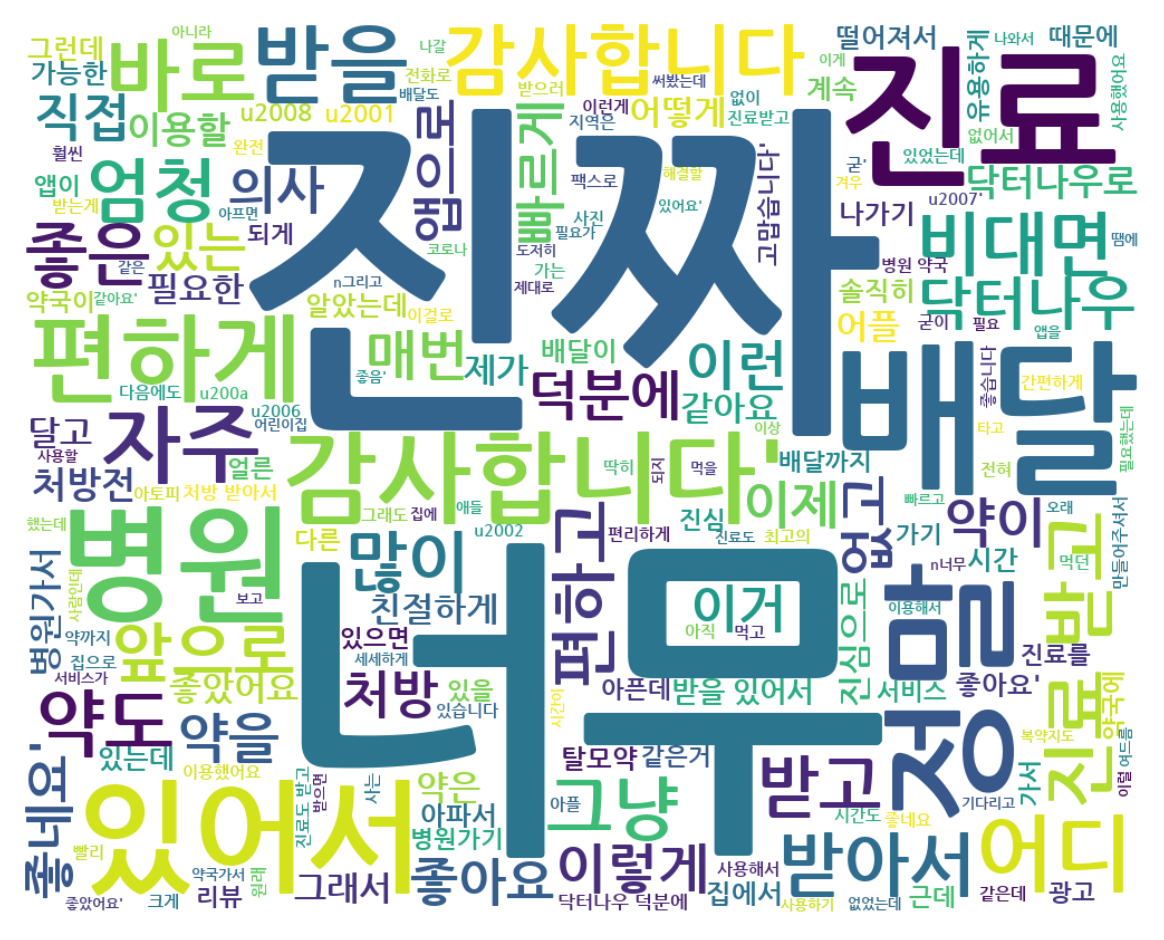

In [ ]:
font_path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
wc = WordCloud(width = 1000, height = 800, background_color="white", font_path=font_path).generate(np.array2string(high_rating_document))
plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2점 이하의 Word Cloud
- 단, 형용사나 명사만 체크하진 않고.. 단순한 word count
- 디벨롭할 수 있는 부분

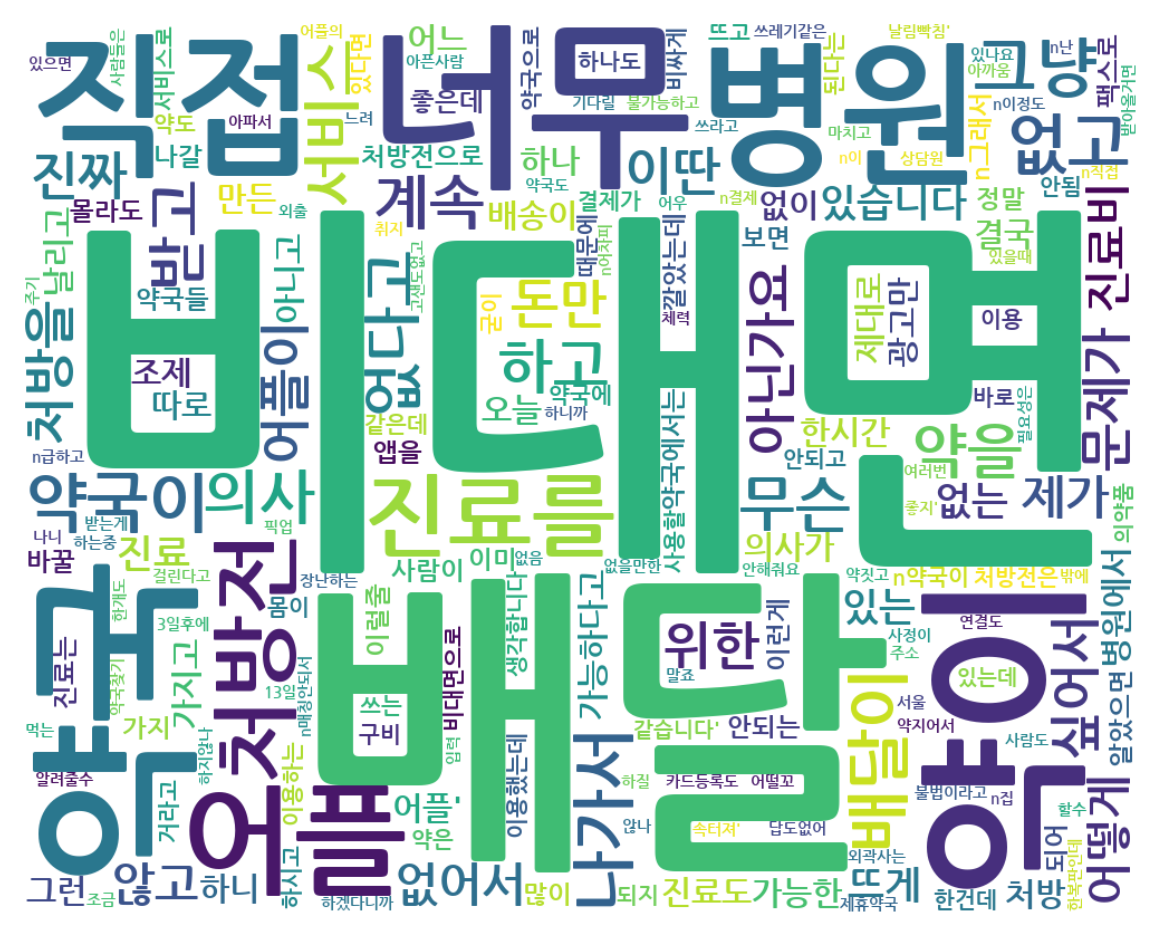

In [ ]:
wc = WordCloud(width = 1000, height = 800, background_color="white", font_path=font_path).generate(np.array2string(low_rating_document))
plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()